# Dynamic Chebyshev Method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
S0 = 36. # current stock price
K = 40. # strike price
r = 0.06 # risk-free rate
σ = 0.2 # volatility
T = 1. # time to maturity, in years, a float number
n_timesteps = 50 # between time 0 and time T, the number of time steps 
dim = 1_000 # number of paths to simulate
n_chebyshev_pol = 100 # degree of chebyshev polynomials
n_chebyshev_point = n_chebyshev_pol + 1 # number of chebyshev points
seed = 150_000 # random seed for reproducibility
np.random.seed(seed)
Z = np.random.normal(0, 1, (dim, n_chebyshev_point)) # white noise (drawn all at once)
Δ = T / n_timesteps

### Define Truncated Domain (here, one-dimensional)

In [3]:
# Truncated general domain, χ
μ = np.log(S0) + (r - 0.5*σ**2)*T
trunc = 3 * np.sqrt(T) * σ # truncate
general_domain = [μ - trunc, μ + trunc] # truncated domain

### Determine Nodal Points

In [4]:
def chebyshev_points_1d(degree: int):
    """
    Calculate the chebyshev points used for one-dimensional interpolation.
    
    Parameters:
    degrees (int): degree of chebyshev polynomial.
        
    Returns:
    1d array
    """
    # x_i = (j * π / N) for i in range 0,...,N
    return np.cos(np.pi * np.linspace(0, 1, degree+1))

def chebyshev_transform_1d(z, a: float, b: float):
    """
    Transform input z from standardized domain [-1,1] to general domain χ.
    
    Parameters:
    z (1d array): chebyshev points on standardized domain [-1,1]
    a (float): lower boundary on domain
    b (float): upper boundary on domain
    
    Returns: 
    1d array of shape z.shape on χ.
    """
    
    return b + 0.5*(a-b)*(1.0-z)

def chebyshev_inverse_transform_1d(x, a: float, b: float):
    """
    Transform input x from general domain χ to standardized domain [-1,1].
    
    Parameters:
    x (1d array): chebyshev points on general domain χ
    a (float): lower boundary of general domain
    b (float): upper boundary of general domain
    
    Returns:
    1d array of shape x.shape
    """
    
    return 2*(x-a)/(b-a) - 1

### Pre-Computation Step

In [5]:
# nodal points
z = chebyshev_points_1d(n_chebyshev_pol) # standardized domain [-1,1]
x = chebyshev_transform_1d(z,general_domain[0],general_domain[1]) # transform to hyperrectangular domain

# Monte Carlo Simulation
# initialize
x_next = np.zeros((dim, n_chebyshev_point))
# simulate stock pricess process
for i in range(n_chebyshev_point):
    x_next[:,i] = x[i] + (r-0.5*σ**2)*Δ + σ*np.sqrt(Δ)*Z[:,i]
    
check = (x_next > general_domain[0]) & (x_next < general_domain[1]) # indicator function
valid_points = np.sum(check, axis=0)

# Compute Generalized Moments
Γ = np.zeros((n_chebyshev_point, n_chebyshev_point)) # initialize
chebypol_eval = np.zeros((dim, n_chebyshev_point, n_chebyshev_point))

for j in range(n_chebyshev_point):
    y = np.zeros(n_chebyshev_point)
    y[j] = 1
    cheb_fun = interp1d(x, y, kind='linear', fill_value="extrapolate")
    chebypol_eval[:,:,j] = cheb_fun(x_next)*check

# nested for loop, very slow
for i in range(n_chebyshev_point):
    for j in range(n_chebyshev_point):
        Γ[i,j] = np.sum(chebypol_eval[:,i,j])/valid_points[i]

### Terminal Period, $t=T$

In [6]:
V = np.zeros((n_chebyshev_point, n_timesteps))
C = np.zeros((n_chebyshev_point, n_timesteps-1))
payoff = np.maximum(K - np.exp(x), 0) # remember to exponentiate since we have form S = e^{x}
V[:,-1] = payoff

### Backward Induction

In [7]:
# Backward induction
for i in range(n_timesteps-2, -1, -1):
    C[:,i] = np.exp(-r*Δ)*Γ@V[:,i+1] # discounted next-period continuation value
    V[:,i] = np.where(payoff>C[:,i], payoff, C[:,i])
    #np.max(np.column_stack((payoff, C[:,i], np.zeros_like(payoff))), axis=1)

### Time zero

In [8]:
# At t = 0
C0 = np.exp(-r*Δ)*Γ@V[:,0]
V0 = interp1d(x, C0, kind='linear', fill_value="extrapolate")(np.log(S0))

In [9]:
V0

array(4.34038684)

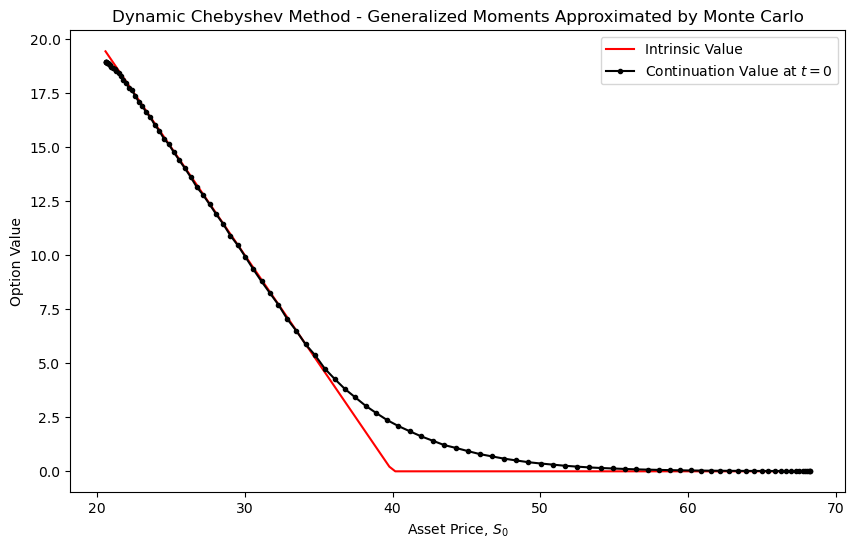

In [10]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot the intrinsic value
asset_prices_range = np.exp(np.arange(general_domain[0], general_domain[1], 0.01))
intrinsic_value = np.maximum(K - asset_prices_range, 0)
plt.plot(asset_prices_range, intrinsic_value, '-r', label='Intrinsic Value')

# Plot the continuation value at t=0
plt.plot(np.exp(x), C[:,0], '.-k', label='Continuation Value at $t=0$')

# Adding labels and title
plt.xlabel('Asset Price, $S_0$')
plt.ylabel('Option Value')
plt.title('Dynamic Chebyshev Method - Generalized Moments Approximated by Monte Carlo')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

# Producing the option surface

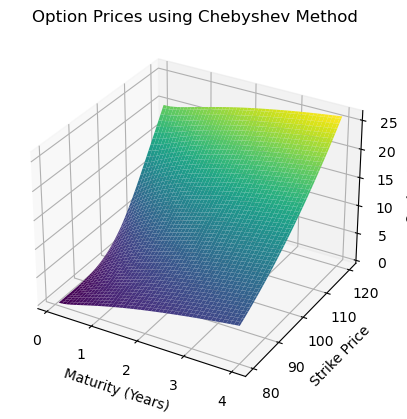

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, interp1d
from mpl_toolkits.mplot3d import Axes3D

# Chebyshev Method Function
def chebyshev_option_price(S0, K, T, σ, r, dim, n_chebyshev_pol, n_timesteps, seed):
    np.random.seed(seed)
    Δ = T / n_timesteps
    Z = np.random.normal(0, 1, (dim, n_chebyshev_pol + 1))

    # Truncated general domain
    μ = np.log(S0) + (r - 0.5 * σ**2) * T
    trunc = 3 * np.sqrt(T) * σ
    general_domain = [μ - trunc, μ + trunc]

    # Chebyshev points and transformation
    z = np.cos(np.pi * np.linspace(0, 1, n_chebyshev_pol + 1))
    x = general_domain[1] + 0.5 * (general_domain[0] - general_domain[1]) * (1.0 - z)

    # Monte Carlo Simulation
    x_next = np.zeros((dim, n_chebyshev_pol + 1))
    for i in range(n_chebyshev_pol + 1):
        x_next[:, i] = x[i] + (r - 0.5 * σ**2) * Δ + σ * np.sqrt(Δ) * Z[:, i]

    check = (x_next > general_domain[0]) & (x_next < general_domain[1])
    valid_points = np.sum(check, axis=0)

    # Compute Generalized Moments
    Γ = np.zeros((n_chebyshev_pol + 1, n_chebyshev_pol + 1))
    for j in range(n_chebyshev_pol + 1):
        y = np.zeros(n_chebyshev_pol + 1)
        y[j] = 1
        cheb_fun = interp1d(x, y, kind='linear', fill_value="extrapolate")
        chebypol_eval = cheb_fun(x_next) * check
        for i in range(n_chebyshev_pol + 1):
            Γ[i, j] = np.sum(chebypol_eval[:, i]) / valid_points[i]

    # Backward Induction
    V = np.zeros((n_chebyshev_pol + 1, n_timesteps))
    payoff = np.maximum(K - np.exp(x), 0)
    V[:, -1] = payoff

    for i in range(n_timesteps - 2, -1, -1):
        C = np.exp(-r * Δ) * Γ @ V[:, i + 1]
        V[:, i] = np.where(payoff > C, payoff, C)

    # At t = 0
    C0 = np.exp(-r * Δ) * Γ @ V[:, 0]
    V0 = interp1d(x, C0, kind='linear', fill_value="extrapolate")(np.log(S0))

    return V0

# Define a range of maturities and strikes
S0 = 100
σ = 0.25
r = 0.03
dim = 1000
n_chebyshev_pol = 100
n_timesteps = 50
seed = 150000

maturities_range = np.array([1/12, 2/12, 3/12, 6/12, 9/12, 1, 15/12, 18/12, 2, 30/12, 3, 4])
strikes_range = np.linspace(0.8 * S0, 1.2 * S0, 10)

# Calculate option prices for each maturity and strike
option_prices = []
maturity_list = []
strike_list = []

for T in maturities_range:
    for K in strikes_range:
        price = chebyshev_option_price(S0, K, T, σ, r, dim, n_chebyshev_pol, n_timesteps, seed)
        option_prices.append(price)
        maturity_list.append(T)
        strike_list.append(K)

# Prepare data for plotting
maturities_np = np.array(maturity_list)
strikes_np = np.array(strike_list)
prices_np = np.array(option_prices)

# Creating a grid for maturities and strikes
maturity_grid, strike_grid = np.meshgrid(np.linspace(maturities_np.min(), maturities_np.max(), 100),
                                         np.linspace(strikes_np.min(), strikes_np.max(), 100))

# Interpolating the prices onto the grid
price_grid = griddata((maturities_np, strikes_np), prices_np, (maturity_grid, strike_grid), method='cubic')

# Plotting the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(maturity_grid, strike_grid, price_grid, cmap='viridis', edgecolor='none')
ax.set_xlabel('Maturity (Years)')
ax.set_ylabel('Strike Price')
ax.set_zlabel('Option Price')
plt.title('Option Prices using Chebyshev Method')

# Save the figure
plt.savefig('ChebyshevMethodSurface.png')

# Show the plot
plt.show()



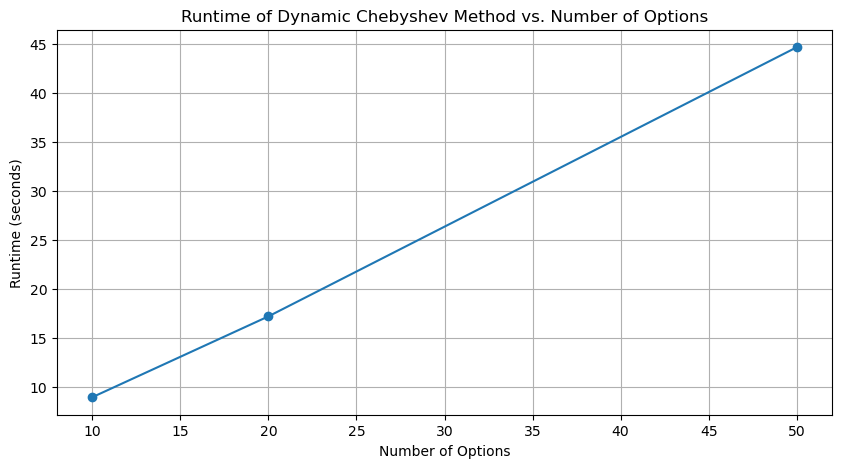

In [10]:
import time

# Assuming chebyshev_option_price function is defined

S0 = 100  # Current stock price
σ = 0.25  # Volatility
r = 0.03  # Risk-free rate
T = 1     # Maturity in years
n_timesteps = 50
dim = 1000
seed = 42
n_chebyshev_pol = 100

# Number of options to test
num_options_list = [10, 20, 50]
runtimes = []

for num_options in num_options_list:
    # Define a range of strikes for the number of options
    strikes_range = np.linspace(0.8 * S0, 1.2 * S0, num_options)

    start_time = time.time()
    
    # Calculate option prices for each strike
    for K in strikes_range:
        _ = chebyshev_option_price(S0, K, T, σ, r, dim, n_chebyshev_pol, n_timesteps, seed)
    
    end_time = time.time()
    runtimes.append(end_time - start_time)

# Plotting Runtime vs. Number of Options
plt.figure(figsize=(10, 5))
plt.plot(num_options_list, runtimes, marker='o')
plt.xlabel('Number of Options')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime of Dynamic Chebyshev Method vs. Number of Options')
plt.grid(True)
plt.show()